This notebook conducts an Exploratory Data Analysis (EDA) on the standardized data that is produced from the methods of the Data-Transformations notebook.

## Import packages:

In [1]:
import gresearch_crypto

from datetime import datetime
import gc
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    return standard_df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

standard_df = standardize_data(df)

In [5]:
standard_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
671913,1555079640,0.0,13.0,17.840000,17.843600,17.840000,17.840100,9.212400e+02,17.841473,-0.001787
671914,1555079700,0.0,12.0,17.840000,17.856500,17.840000,17.847100,1.270400e+02,17.846861,-0.001602
671915,1555079760,0.0,22.0,17.856500,17.860000,17.850400,17.850400,1.261230e+03,17.857771,-0.000504
671916,1555079820,0.0,5.0,17.859400,17.859500,17.845600,17.859500,2.382000e+01,17.848033,0.000566
671917,1555079880,0.0,4.0,17.853200,17.858300,17.849900,17.849900,3.577000e+02,17.850593,0.000000
...,...,...,...,...,...,...,...,...,...,...
26080009,1632181200,13.0,986.0,0.090885,0.091054,0.090710,0.090941,5.734456e+06,0.090831,0.000199
26080010,1632181260,13.0,715.0,0.091010,0.091277,0.090980,0.091203,1.989048e+06,0.091125,-0.003477
26080011,1632181320,13.0,527.0,0.091171,0.091295,0.091092,0.091180,2.386078e+06,0.091185,-0.002437
26080012,1632181380,13.0,463.0,0.091206,0.091290,0.091028,0.091081,1.568854e+06,0.091131,0.004843


In [6]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Stationarity EDA

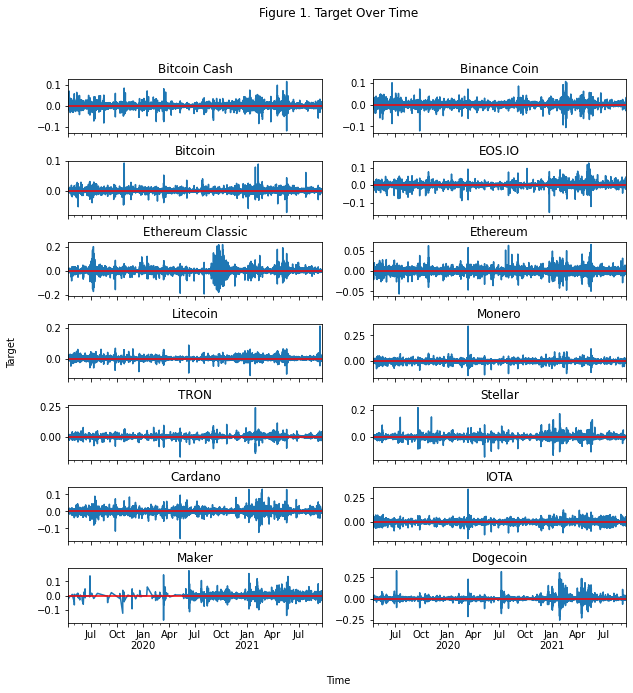

In [7]:
standard_df.loc[:, "datetime"] = pd.to_datetime(standard_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    standard_df.loc[standard_df["Asset_ID"] == asset].plot(x = "datetime",
        y = "Target", ax = ax, legend = False, xlabel = "", ylabel = "",
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    ax.axhline(y = standard_df.loc[standard_df["Asset_ID"] == asset, "Target"].mean(), 
             xmin = 0, xmax = 1, color = "r")
    
fig.suptitle("Figure 1. Target Over Time")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)
    
plt.show()

In [8]:
del fig
del axes
del df
gc.collect()

54

Shown above, the values of target during the course of the standardized dataset appear stationary by visual appearance. 

They can be formally investigated with a Augmented Dickey-Fuller hypothesis test.

In [9]:
# manual loop to increase time but decrease memory
for asset in asset_details_df["Asset_ID"]:
    
    gc.collect()
    
    print(asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
    # get every nth row for test with full lags
    n = 20
    maxlags = 20
    
    # conduct tests and get p-value
    
    print("\tFull Lags on Subset of Data:")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Target"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("\tFull Lags on Random Sample of Data:")
    # full lags but random sample of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Target"].sample(frac = 1/n).sort_index(), 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("\tFirst Lags on Full Data:")
    # first lags but full data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Target"], 
                   maxlag = maxlags, regression = "nc")[1])
    print("")
    
    gc.collect()

Bitcoin Cash
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

Binance Coin
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

Bitcoin
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

EOS.IO
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

Ethereum Classic
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

Ethereum
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

Litecoin
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

Monero
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of Data:
0.0
	First Lags on Full Data:
0.0

TRON
	Full Lags on Subset of Data:
0.0
	Full Lags on Random Sample of

Above, it can clearly be seen that all data subsetting methods for all coins result in a p-value of near zero. Therefore, the null hypothesis that an individual series is not stationary is rejected. The alternative hypothesis that an individual series is stationary is failed to be rejected.

To better determine if these data subsetting methods produce similar results, and to take the most conservative for use in the future, the test statistics can be viewed for the most popular coins, Bitcoin and Ethereum.

In [10]:
# manual loop to increase time but decrease memory
for asset in [1, 6]:
    
    gc.collect()
    
    print(asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    # get every nth row for test with full lags
    n = 20
    maxlags = 20
    
    # conduct tests and get p-value
    
    print("\tFull Lags on Subset of Data:")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Target"].iloc[::n], 
                   regression = "nc")[0])
    
    gc.collect()
    
    print("\tFull Lags on Random Sample of Data:")
    # full lags but random sample of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Target"].sample(frac = 1/n).sort_index(), 
                   regression = "nc")[0])
    
    gc.collect()
    
    print("\tFirst Lags on Full Data:")
    # first lags but full data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Target"], 
                   maxlag = maxlags, regression = "nc")[0])
    print("")
    
    gc.collect()

Bitcoin
	Full Lags on Subset of Data:
-33.12062526524114
	Full Lags on Random Sample of Data:
-29.57478259180889
	First Lags on Full Data:
-178.6359310972742

Ethereum
	Full Lags on Subset of Data:
-34.926488854459315
	Full Lags on Random Sample of Data:
-30.969274422119156
	First Lags on Full Data:
-185.89500696544115



It can be seen that the smallest test statistics, which is least likely to reject the null hypothesis and thus be the most conservative, is when using the test with full lags but on a subset of the data based on repeated intervals. Therefore, this method should be used when evaluating future tests on other aspects of the data.

It will also be important to know if other variables are stationary, which will now be evaluated with this method.

In [11]:
print("\tFull Lags on Subset of Data:")
# manual loop to increase time but decrease memory
for asset in asset_details_df["Asset_ID"]:
    
    gc.collect()
    print()
    print(asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
    # get every nth row for test with full lags
    n = 20
    
    # conduct tests and get p-value
    
    print("Open")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Open"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("High")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "High"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("Low")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Low"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("Close")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Close"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("Volume")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "Volume"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("VWAP")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "VWAP"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()

	Full Lags on Subset of Data:

Bitcoin Cash
Open
0.33618985088290776
High
0.3331491877198591
Low
0.3371797117938916
Close
0.33814344616368586
Volume
5.760155987035316e-18
VWAP
0.33765296229018016

Binance Coin
Open
0.6139538029417477
High
0.6097491174953515
Low
0.6190393039020291
Close
0.6174199291283826
Volume
5.865807882338929e-15
VWAP
0.6161263617618169

Bitcoin
Open
0.7901842885888948
High
0.7946991750335539
Low
0.8046810986638437
Close
0.7945840197375842
Volume
8.12685698861181e-17
VWAP
0.8004330884193233

EOS.IO
Open
0.179797296885294
High
0.1778930204660184
Low
0.1818547672433442
Close
0.18145055548781336
Volume
9.963576804914312e-20
VWAP
0.18131746636794377

Ethereum Classic
Open
0.16434457714177536
High
0.18256795752929272
Low
0.1601696775646675
Close
0.1705906078758982
Volume
2.893030591770396e-19
VWAP
0.1721341385589138

Ethereum
Open
0.8665703112685309
High
0.8668389284184637
Low
0.8661175492814044
Close
0.8648412277825444
Volume
1.5656576889513196e-16
VWAP
0.86820573446487

Every coin is non-stationary in all other continuous variables except for Volume. Further, for a single coin each non-stationary variable has about the same p-value. 

To turn these series stationary, different transformations should be developed coin by coin. Because these variables exhibit the same degree of non-stationarity, only one variable will be examined for each to develop transformations, assuming that these will also make the other variables for the coin stationary as well. Opening price will be used for this purpose.

First, Open will be visualized for each coin.

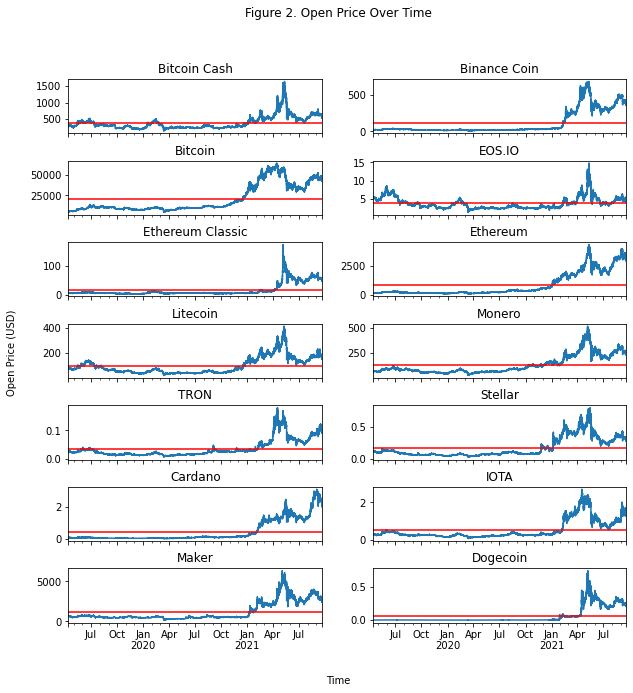

In [12]:
gc.collect()

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    standard_df.loc[standard_df["Asset_ID"] == asset].plot(x = "datetime",
        y = "Open", ax = ax, legend = False, xlabel = "", ylabel = "",
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    ax.axhline(y = standard_df.loc[standard_df["Asset_ID"] == asset, "Open"].mean(), 
             xmin = 0, xmax = 1, color = "r")
    
fig.suptitle("Figure 2. Open Price Over Time")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Open Price (USD)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)
    
plt.show()

Clearly, increasing prices of crypto currencies over time creates a positive trend. With added speculation, variance increases over time as well. 

This can each be addressed with first differencing and a logarithm transformation respectively.

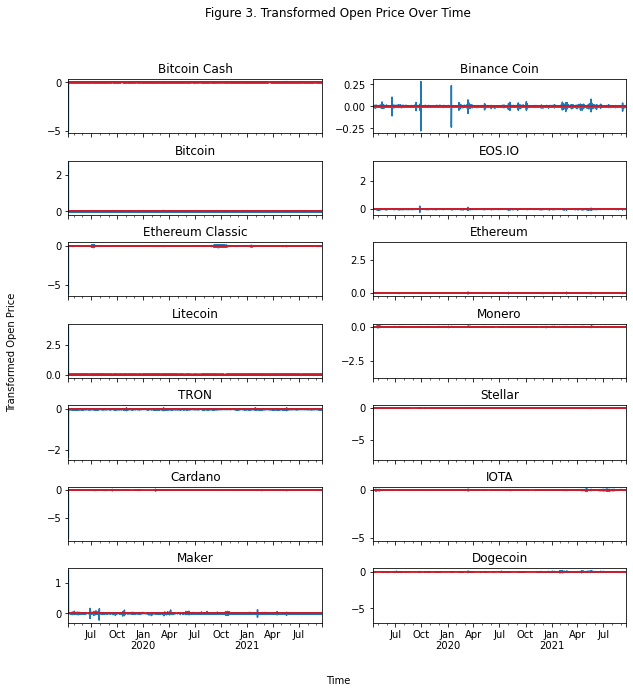

In [13]:
gc.collect()

standard_df["open_t"] = (np.log(standard_df["Open"].copy())).diff()
standard_df.fillna(0, inplace = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    standard_df.loc[standard_df["Asset_ID"] == asset].plot(x = "datetime",
        y = "open_t", ax = ax, legend = False, xlabel = "", ylabel = "",
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    ax.axhline(y = standard_df.loc[standard_df["Asset_ID"] == asset, "open_t"].mean(), 
             xmin = 0, xmax = 1, color = "r")
    
fig.suptitle("Figure 3. Transformed Open Price Over Time")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Transformed Open Price', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)
    
plt.show()

Shown above, a few outliers caused from the first difference operation drastically changes the scale of the y-axis.

The same stationarity tests can now be repeated for the transformed series for a numerical evaluation.

In [14]:
gc.collect()

standard_df["close_t"] = (np.log(standard_df["Close"])).diff()
standard_df["high_t"] = (np.log(standard_df["High"])).diff()
standard_df["low_t"] = (np.log(standard_df["Low"])).diff()
standard_df["vwap_t"] = (np.log(standard_df["VWAP"])).diff()
standard_df.fillna(0, inplace = True)

print("\tFull Lags on Subset of Data:")
# manual loop to increase time but decrease memory
for asset in asset_details_df["Asset_ID"]:
    
    gc.collect()
    print()
    print(asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
    # get every nth row for test with full lags
    n = 20
    
    # conduct tests and get p-value
    
    print("Open")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "open_t"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("High")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "high_t"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("Low")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "low_t"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("Close")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "close_t"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()
    
    print("VWAP")
    # full lags but subset of data
    print(adfuller(standard_df.loc[(standard_df["Asset_ID"] == asset), "vwap_t"].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


	Full Lags on Subset of Data:

Bitcoin Cash
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Binance Coin
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Bitcoin
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

EOS.IO
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Ethereum Classic
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Ethereum
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Litecoin
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Monero
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

TRON
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Stellar
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Cardano
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

IOTA
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Maker
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0

Dogecoin
Open
0.0
High
0.0
Low
0.0
Close
0.0
VWAP
0.0


Now, all of these variables for all coins are stationary suggesting that the logarithm and first difference transformation is adequate. 